# Scratching

In [1]:
import os
import ssl
import sqlalchemy
from dotenv import load_dotenv
from pathlib import Path

dotenv_path = Path(".env/.env_credential")
load_dotenv(dotenv_path=dotenv_path)

# os.environ["INSTANCE_HOST"] = "127.0.0.1"
# os.environ["DB_USER"] = "Your_DB_User"
# os.environ["DB_PASS"] = "Your_DB_Pass"
# os.environ["DB_NAME"] = "Your_DB_Name"
# os.environ["DB_PORT"] = "5432"

True

## Local Computer (Development Mode)

with Cloud SQL Auth Proxy, for more info and step-by-step: https://cloud.google.com/sql/docs/postgres/connect-instance-auth-proxy

In [2]:
# Source: https://github.com/GoogleCloudPlatform/python-docs-samples/blob/b1dc90145269bdabdda0a97805ebc5f589f4b3d2/cloud-sql/postgres/sqlalchemy/connect_tcp.py
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TODO (https://github.com/GoogleCloudPlatform/python-docs-samples/issues/8253): remove old region tags
# [START cloud_sql_postgres_sqlalchemy_connect_tcp]
# [START cloud_sql_postgres_sqlalchemy_sslcerts]
# [START cloud_sql_postgres_sqlalchemy_connect_tcp_sslcerts]

def connect_tcp_socket() -> sqlalchemy.engine.base.Engine:
    """Initializes a TCP connection pool for a Cloud SQL instance of Postgres."""
    # Note: Saving credentials in environment variables is convenient, but not
    # secure - consider a more secure solution such as
    # Cloud Secret Manager (https://cloud.google.com/secret-manager) to help
    # keep secrets safe.
    db_host = os.environ[
        "INSTANCE_HOST"
    ]  # e.g. '127.0.0.1' ('172.17.0.1' if deployed to GAE Flex)
    db_user = os.environ["DB_USER"]  # e.g. 'my-db-user'
    db_pass = os.environ["DB_PASS"]  # e.g. 'my-db-password'
    db_name = os.environ["DB_NAME"]  # e.g. 'my-database'
    db_port = os.environ["DB_PORT"]  # e.g. 5432

    # [END cloud_sql_postgres_sqlalchemy_connect_tcp]
    connect_args = {}
    # For deployments that connect directly to a Cloud SQL instance without
    # using the Cloud SQL Proxy, configuring SSL certificates will ensure the
    # connection is encrypted.
    if os.environ.get("DB_ROOT_CERT"):
        db_root_cert = os.environ["DB_ROOT_CERT"]  # e.g. '/path/to/my/server-ca.pem'
        db_cert = os.environ["DB_CERT"]  # e.g. '/path/to/my/client-cert.pem'
        db_key = os.environ["DB_KEY"]  # e.g. '/path/to/my/client-key.pem'

        ssl_context = ssl.SSLContext()
        ssl_context.verify_mode = ssl.CERT_REQUIRED
        ssl_context.load_verify_locations(db_root_cert)
        ssl_context.load_cert_chain(db_cert, db_key)
        connect_args["ssl_context"] = ssl_context

    # [START cloud_sql_postgres_sqlalchemy_connect_tcp]
    pool = sqlalchemy.create_engine(
        # Equivalent URL:
        # postgresql+pg8000://<db_user>:<db_pass>@<db_host>:<db_port>/<db_name>
        sqlalchemy.engine.url.URL.create(
            drivername="postgresql+pg8000",
            username=db_user,
            password=db_pass,
            host=db_host,
            port=db_port,
            database=db_name,
        ),
        # [END cloud_sql_postgres_sqlalchemy_connect_tcp]
        connect_args=connect_args,
        # [START cloud_sql_postgres_sqlalchemy_connect_tcp]
        # [START_EXCLUDE]
        # [START cloud_sql_postgres_sqlalchemy_limit]
        # Pool size is the maximum number of permanent connections to keep.
        pool_size=5,
        # Temporarily exceeds the set pool_size if no connections are available.
        max_overflow=2,
        # The total number of concurrent connections for your application will be
        # a total of pool_size and max_overflow.
        # [END cloud_sql_postgres_sqlalchemy_limit]
        # [START cloud_sql_postgres_sqlalchemy_backoff]
        # SQLAlchemy automatically uses delays between failed connection attempts,
        # but provides no arguments for configuration.
        # [END cloud_sql_postgres_sqlalchemy_backoff]
        # [START cloud_sql_postgres_sqlalchemy_timeout]
        # 'pool_timeout' is the maximum number of seconds to wait when retrieving a
        # new connection from the pool. After the specified amount of time, an
        # exception will be thrown.
        pool_timeout=30,  # 30 seconds
        # [END cloud_sql_postgres_sqlalchemy_timeout]
        # [START cloud_sql_postgres_sqlalchemy_lifetime]
        # 'pool_recycle' is the maximum number of seconds a connection can persist.
        # Connections that live longer than the specified amount of time will be
        # re-established
        pool_recycle=1800,  # 30 minutes
        # [END cloud_sql_postgres_sqlalchemy_lifetime]
        # [END_EXCLUDE]
    )
    return pool


# [END cloud_sql_postgres_sqlalchemy_connect_tcp_sslcerts]
# [END cloud_sql_postgres_sqlalchemy_sslcerts]
# [END cloud_sql_postgres_sqlalchemy_connect_tcp]

In [4]:
def init_db() -> sqlalchemy.engine.base.Engine:
    global db
    db = connect_tcp_socket()

init_db()

Schema of main table predict:
<div style="font-size:10px; overflow-x:scroll">

| date | user_id | task_exe_completed | task_med_completed | task_read_completed | act_exe_num | act_med_num | act_read_num | act_exe_nununique | act_med_nununique | act_read_nununique | streak_current |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 2023-08-20T09:03:55.100Z | 62b02ffc-3acf-11ee-a54d-fc349773721c | 1 | 0 | 1 | 2 | 1 | 4 | 2 | 1 | 1 | 7 |

<div>

Number of columns: 10 (feature / column)  
List related table-columns:
- users_task_log (task_exe_completed, task_med_completed, task_read_completed)
- users_activity_log (act_exe_num, act_med_num, act_read_num, act_exe_nununique, act_med_nununique, act_read_nununique)
- users_game_stats (streak_current)

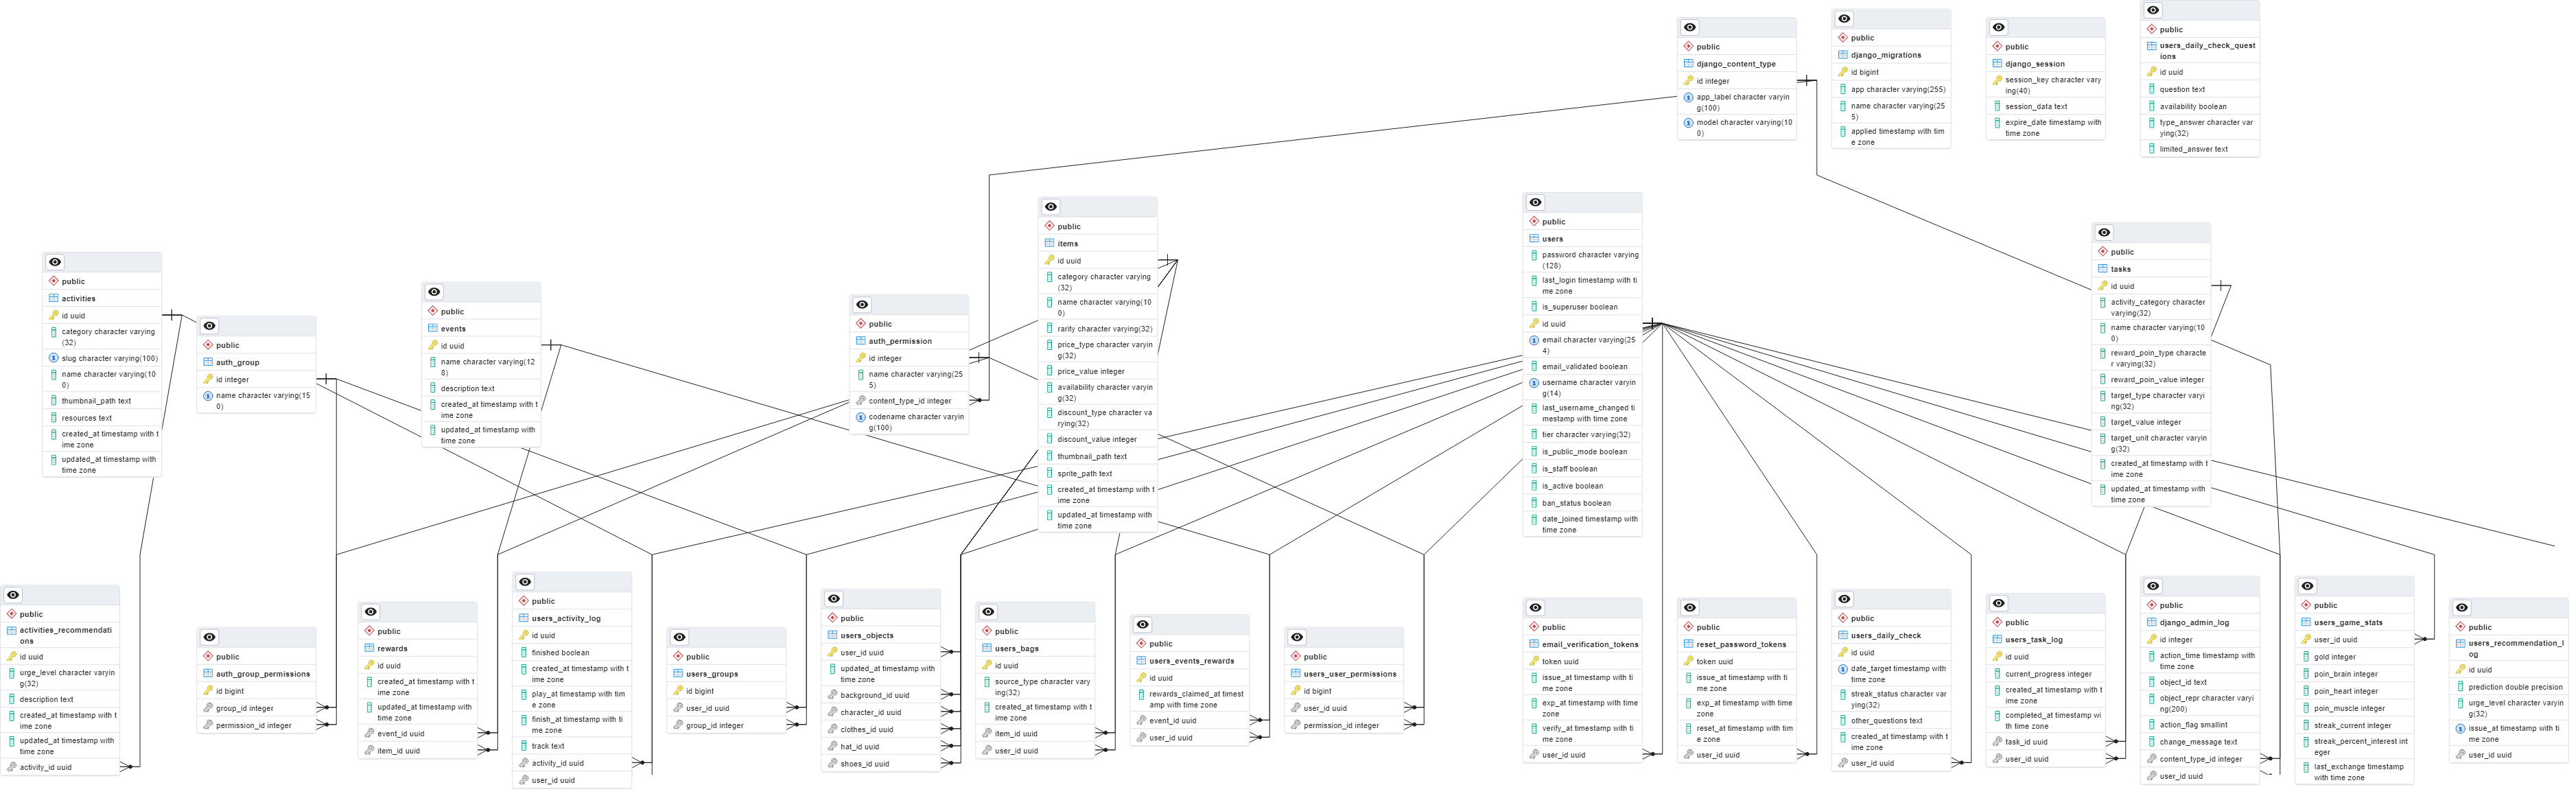

Notes:
- Predict each day for each user if yesterday already did >= 1 activity or task or if user go /home that will trigger to create task even without does task / activity

Flow:
- Date and user_id by users_task_log table since if user only do one activity it will be auto generated task log
- From users_task_log get [user_id, task_id__activity_category, created_at, completed_at]
- Do preprocessing to be flattened df1=[date, user_id, task_exe_completed, task_med_completed, task_read_completed]
- and create list_user_id from result above
- From users_activity_log get [user_id, activity_id, activity_id__category] with list_user_id, play_at=date, and finished=true
- activity_id will be used to determine nununique activities
- Do preprocessing to be flattened df2=[user_id, act_exe_num, act_med_num, act_read_num, act_exe_nununique, act_med_nununique, act_read_nununique]
- From users_game_stats get df=3[user_id, streak_current]
- Do preprocessing combine df1, df2, df3
- Send request to tensorflow serving
- After get response save into users_recommendation_log [user_id, urge_level, prediction]
- Done!

In [6]:
with db.connect() as conn:
    recent_users = conn.execute(
        sqlalchemy.text(
            "SELECT * FROM users_game_stats"
        )
    ).fetchall()

    print(recent_users)

[(UUID('62b02ffc-3acf-11ee-a54d-fc349773721c'), 0, 0, 0, 0, 0, 0, None), (UUID('8aba04dc-3c4e-11ee-8912-b9abc6be66df'), 0, 0, 0, 0, 0, 0, None)]
